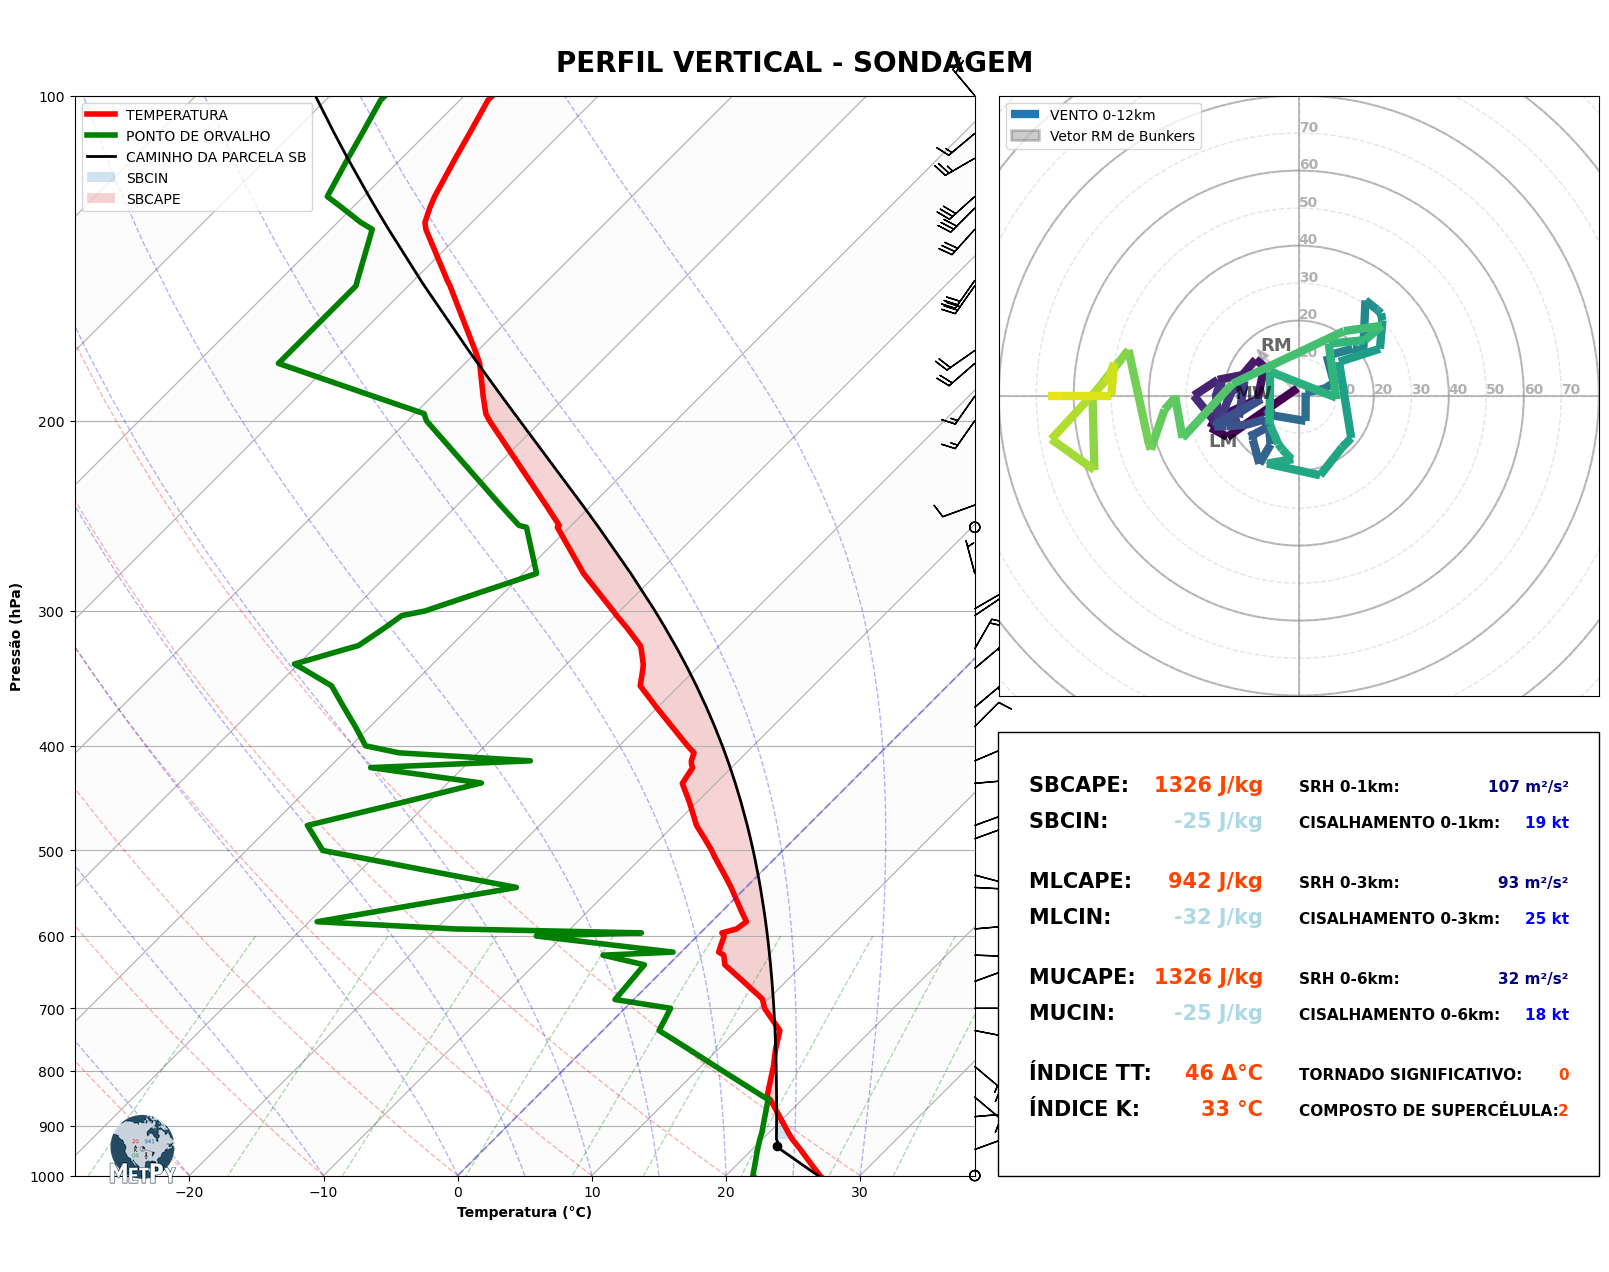

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

# Lendo os dados do arquivo sondagem.csv
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']
df = pd.read_csv('sondagem.csv', skiprows=1, usecols=[1, 2, 3, 4, 9, 10], names=col_names)

# Removendo linhas com valores NaN para temperatura, ponto de orvalho e ventos
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all').reset_index(drop=True)

# Extraindo variáveis e atribuindo unidades
p = df['pressure'].values * units.hPa
z = df['height'].values * units.m
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Criando a figura com proporções adequadas
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))
add_metpy_logo(fig, 105, 85, size='small')

# Ajustando limites de dados e aparência
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperatura (°C)', weight='bold')
skew.ax.set_ylabel('Pressão (hPa)', weight='bold')
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Adicionando padrão de isotermas sombreadas
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# Plotando temperatura, ponto de orvalho e barbelas de vento
skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
skew.plot(p, Td, 'g', lw=4, label='PONTO DE ORVALHO')
interval = np.logspace(2, 3, 40) * units.hPa # Menos barbelas
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

# Adicionando linhas especiais e ajustando aparência
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculando e plotando LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculando e plotando perfil da parcela
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='CAMINHO DA PARCELA SB')

# Sombreando áreas de CAPE e CIN
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='SBCIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='SBCAPE')

# Criando o hodógrafo
hodo_ax = plt.axes((0.48, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
h.plot_colormapped(u, v, c=z, linewidth=6, label='VENTO 0-12km')

# Calculando movimento de tempestade de Bunkers
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black', alpha=0.2, label='Vetor RM de Bunkers', length_includes_head=True, head_width=2)

# Adicionando retângulo para parâmetros
fig.patches.extend([plt.Rectangle((0.563, 0.05), 0.334, 0.37, edgecolor='black', facecolor='white', linewidth=1, alpha=1, transform=fig.transFigure, figure=fig)])

# Calculando parâmetros meteorológicos
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km, storm_u=u_storm, storm_v=v_storm)
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height, total_helicity3, bshear3).to_base_units()
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# Plotando parâmetros termodinâmicos
plt.figtext(0.58, 0.37, 'SBCAPE: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.37, f'{sbcape:.0f~P}', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.34, 'SBCIN: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.34, f'{sbcin:.0f~P}', weight='bold', fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.29, 'MLCAPE: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.29, f'{mlcape:.0f~P}', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.26, 'MLCIN: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.26, f'{mlcin:.0f~P}', weight='bold', fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.21, 'MUCAPE: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.21, f'{mucape:.0f~P}', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.18, 'MUCIN: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.18, f'{mucin:.0f~P}', weight='bold', fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.13, 'ÍNDICE TT: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.13, f'{total_totals:.0f~P}', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.10, 'ÍNDICE K: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.10, f'{kindex:.0f~P}', weight='bold', fontsize=15, color='orangered', ha='right')

# Plotando parâmetros cinemáticos
plt.figtext(0.73, 0.37, 'SRH 0-1km: ', weight='bold', fontsize=11, color='black', ha='left')
plt.figtext(0.88, 0.37, f'{total_helicity1:.0f~P}', weight='bold', fontsize=11, color='navy', ha='right')
plt.figtext(0.73, 0.34, 'CISALHAMENTO 0-1km: ', weight='bold', fontsize=11, color='black', ha='left')
plt.figtext(0.88, 0.34, f'{bshear1:.0f~P}', weight='bold', fontsize=11, color='blue', ha='right')
plt.figtext(0.73, 0.29, 'SRH 0-3km: ', weight='bold', fontsize=11, color='black', ha='left')
plt.figtext(0.88, 0.29, f'{total_helicity3:.0f~P}', weight='bold', fontsize=11, color='navy', ha='right')
plt.figtext(0.73, 0.26, 'CISALHAMENTO 0-3km: ', weight='bold', fontsize=11, color='black', ha='left')
plt.figtext(0.88, 0.26, f'{bshear3:.0f~P}', weight='bold', fontsize=11, color='blue', ha='right')
plt.figtext(0.73, 0.21, 'SRH 0-6km: ', weight='bold', fontsize=11, color='black', ha='left')
plt.figtext(0.88, 0.21, f'{total_helicity6:.0f~P}', weight='bold', fontsize=11, color='navy', ha='right')
plt.figtext(0.73, 0.18, 'CISALHAMENTO 0-6km: ', weight='bold', fontsize=11, color='black', ha='left')
plt.figtext(0.88, 0.18, f'{bshear6:.0f~P}', weight='bold', fontsize=11, color='blue', ha='right')
plt.figtext(0.73, 0.13, 'TORNADO SIGNIFICATIVO: ', weight='bold', fontsize=11, color='black', ha='left')
plt.figtext(0.88, 0.13, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=11, color='orangered', ha='right')
plt.figtext(0.73, 0.10, 'COMPOSTO DE SUPERCÉLULA: ', weight='bold', fontsize=11, color='black', ha='left')
plt.figtext(0.88, 0.10, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=11, color='orangered', ha='right')

# Adicionando legendas
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# Adicionando título
plt.figtext(0.45, 0.97, 'PERFIL VERTICAL - SONDAGEM', weight='bold', fontsize=20, ha='center')

# Exibindo o gráfico
plt.show()

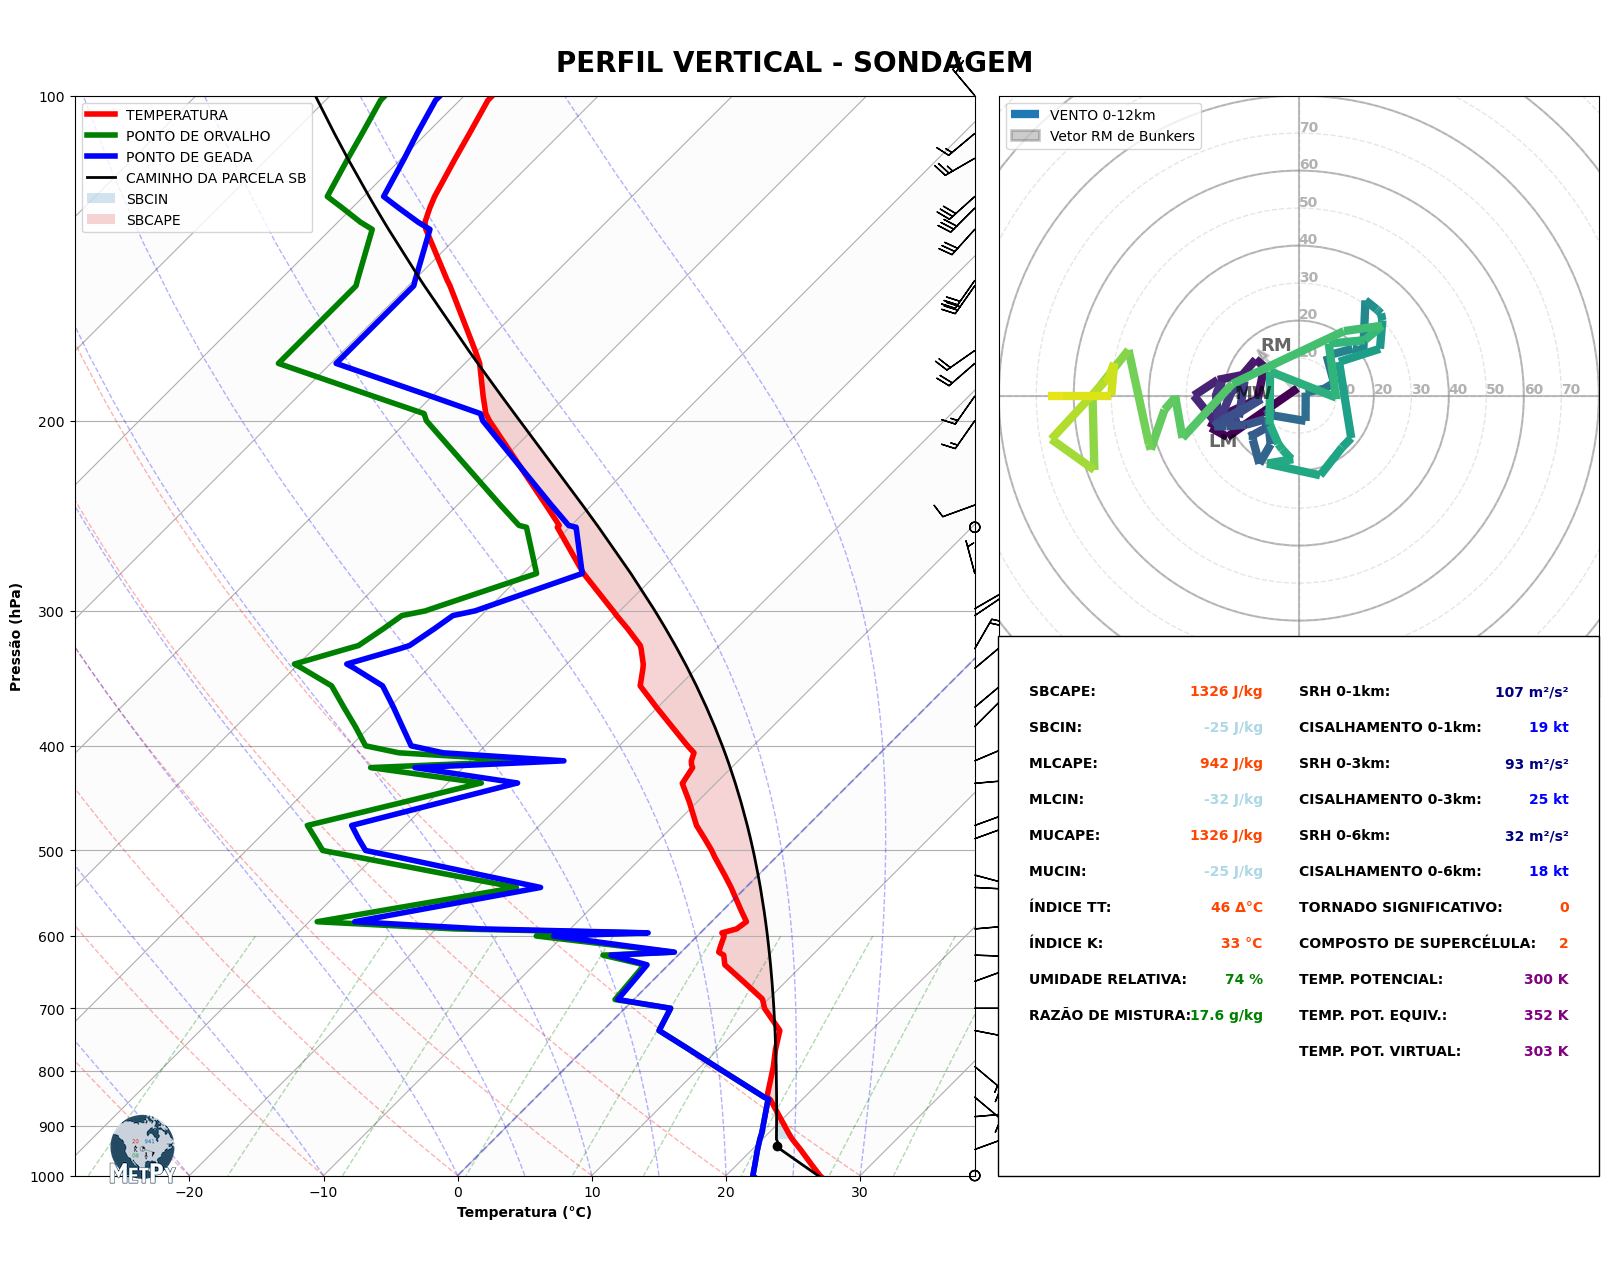

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

# Lendo os dados do arquivo sondagem.csv com todas as colunas desejadas
col_names = [
    'pressure', 'height', 'temperature', 'dewpoint', 'frost_point', 'relativehumidity',
    'relativehumiditywithrespecttoice', 'mixing_ratio', 'direction', 'speed',
    'potentialtemperature', 'equivalentpotentialtemperature', 'virtualpotentialtemperature'
]
usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
df = pd.read_csv('sondagem.csv', skiprows=1, usecols=usecols, names=col_names)

# Removendo linhas com valores NaN para temperatura, ponto de orvalho e ventos
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all').reset_index(drop=True)

# Extraindo variáveis e atribuindo unidades
p = df['pressure'].values * units.hPa
z = df['height'].values * units.m
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
Tf = df['frost_point'].values * units.degC
rh = df['relativehumidity'].values * units.percent
rhi = df['relativehumiditywithrespecttoice'].values * units.percent
mixr = df['mixing_ratio'].values * units('g/kg')
theta = df['potentialtemperature'].values * units.kelvin
theta_e = df['equivalentpotentialtemperature'].values * units.kelvin
theta_v = df['virtualpotentialtemperature'].values * units.kelvin
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Criando a figura com proporções adequadas
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))
add_metpy_logo(fig, 105, 85, size='small')

# Ajustando limites de dados e aparência
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperatura (°C)', weight='bold')
skew.ax.set_ylabel('Pressão (hPa)', weight='bold')
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Adicionando padrão de isotermas sombreadas
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# Plotando temperatura, ponto de orvalho, ponto de geada e barbelas de vento
skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
skew.plot(p, Td, 'g', lw=4, label='PONTO DE ORVALHO')
skew.plot(p, Tf, 'b', lw=4, label='PONTO DE GEADA')
interval = np.logspace(2, 3, 40) * units.hPa  # Menos barbelas
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

# Adicionando linhas especiais e ajustando aparência
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculando e plotando LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculando e plotando perfil da parcela
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='CAMINHO DA PARCELA SB')

# Sombreando áreas de CAPE e CIN
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='SBCIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='SBCAPE')

# Criando o hodógrafo
hodo_ax = plt.axes((0.48, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
h.plot_colormapped(u, v, c=z, linewidth=6, label='VENTO 0-12km')

# Calculando movimento de tempestade de Bunkers
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black', alpha=0.2, label='Vetor RM de Bunkers', length_includes_head=True, head_width=2)

# Adicionando retângulo para parâmetros (aumentado para acomodar mais parâmetros)
fig.patches.extend([plt.Rectangle((0.563, 0.05), 0.334, 0.45, edgecolor='black', facecolor='white', linewidth=1, alpha=1, transform=fig.transFigure, figure=fig)])

# Calculando parâmetros meteorológicos
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km, storm_u=u_storm, storm_v=v_storm)
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height, total_helicity3, bshear3).to_base_units()
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# Plotando parâmetros termodinâmicos (ajustado para incluir novos parâmetros)
plt.figtext(0.58, 0.45, 'SBCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.45, f'{sbcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.58, 0.42, 'SBCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.42, f'{sbcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.58, 0.39, 'MLCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.39, f'{mlcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.58, 0.36, 'MLCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.36, f'{mlcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.58, 0.33, 'MUCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.33, f'{mucape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.58, 0.30, 'MUCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.30, f'{mucin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.58, 0.27, 'ÍNDICE TT: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.27, f'{total_totals:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.58, 0.24, 'ÍNDICE K: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.24, f'{kindex:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.58, 0.21, 'UMIDADE RELATIVA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.21, f'{rh[0]:.0f~P}', weight='bold', fontsize=10, color='green', ha='right')
plt.figtext(0.58, 0.18, 'RAZÃO DE MISTURA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.71, 0.18, f'{mixr[0]:.1f~P}', weight='bold', fontsize=10, color='green', ha='right')

# Plotando parâmetros cinemáticos
plt.figtext(0.73, 0.45, 'SRH 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.45, f'{total_helicity1:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.73, 0.42, 'CISALHAMENTO 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.42, f'{bshear1:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.73, 0.39, 'SRH 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.39, f'{total_helicity3:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.73, 0.36, 'CISALHAMENTO 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.36, f'{bshear3:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.73, 0.33, 'SRH 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.33, f'{total_helicity6:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.73, 0.30, 'CISALHAMENTO 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.30, f'{bshear6:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.73, 0.27, 'TORNADO SIGNIFICATIVO: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.27, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.73, 0.24, 'COMPOSTO DE SUPERCÉLULA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.24, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.73, 0.21, 'TEMP. POTENCIAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.21, f'{theta[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.73, 0.18, 'TEMP. POT. EQUIV.: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.18, f'{theta_e[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.73, 0.15, 'TEMP. POT. VIRTUAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.88, 0.15, f'{theta_v[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')

# Adicionando legendas
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# Adicionando título
plt.figtext(0.45, 0.97, 'PERFIL VERTICAL - SONDAGEM', weight='bold', fontsize=20, ha='center')

# Exibindo o gráfico
plt.show()

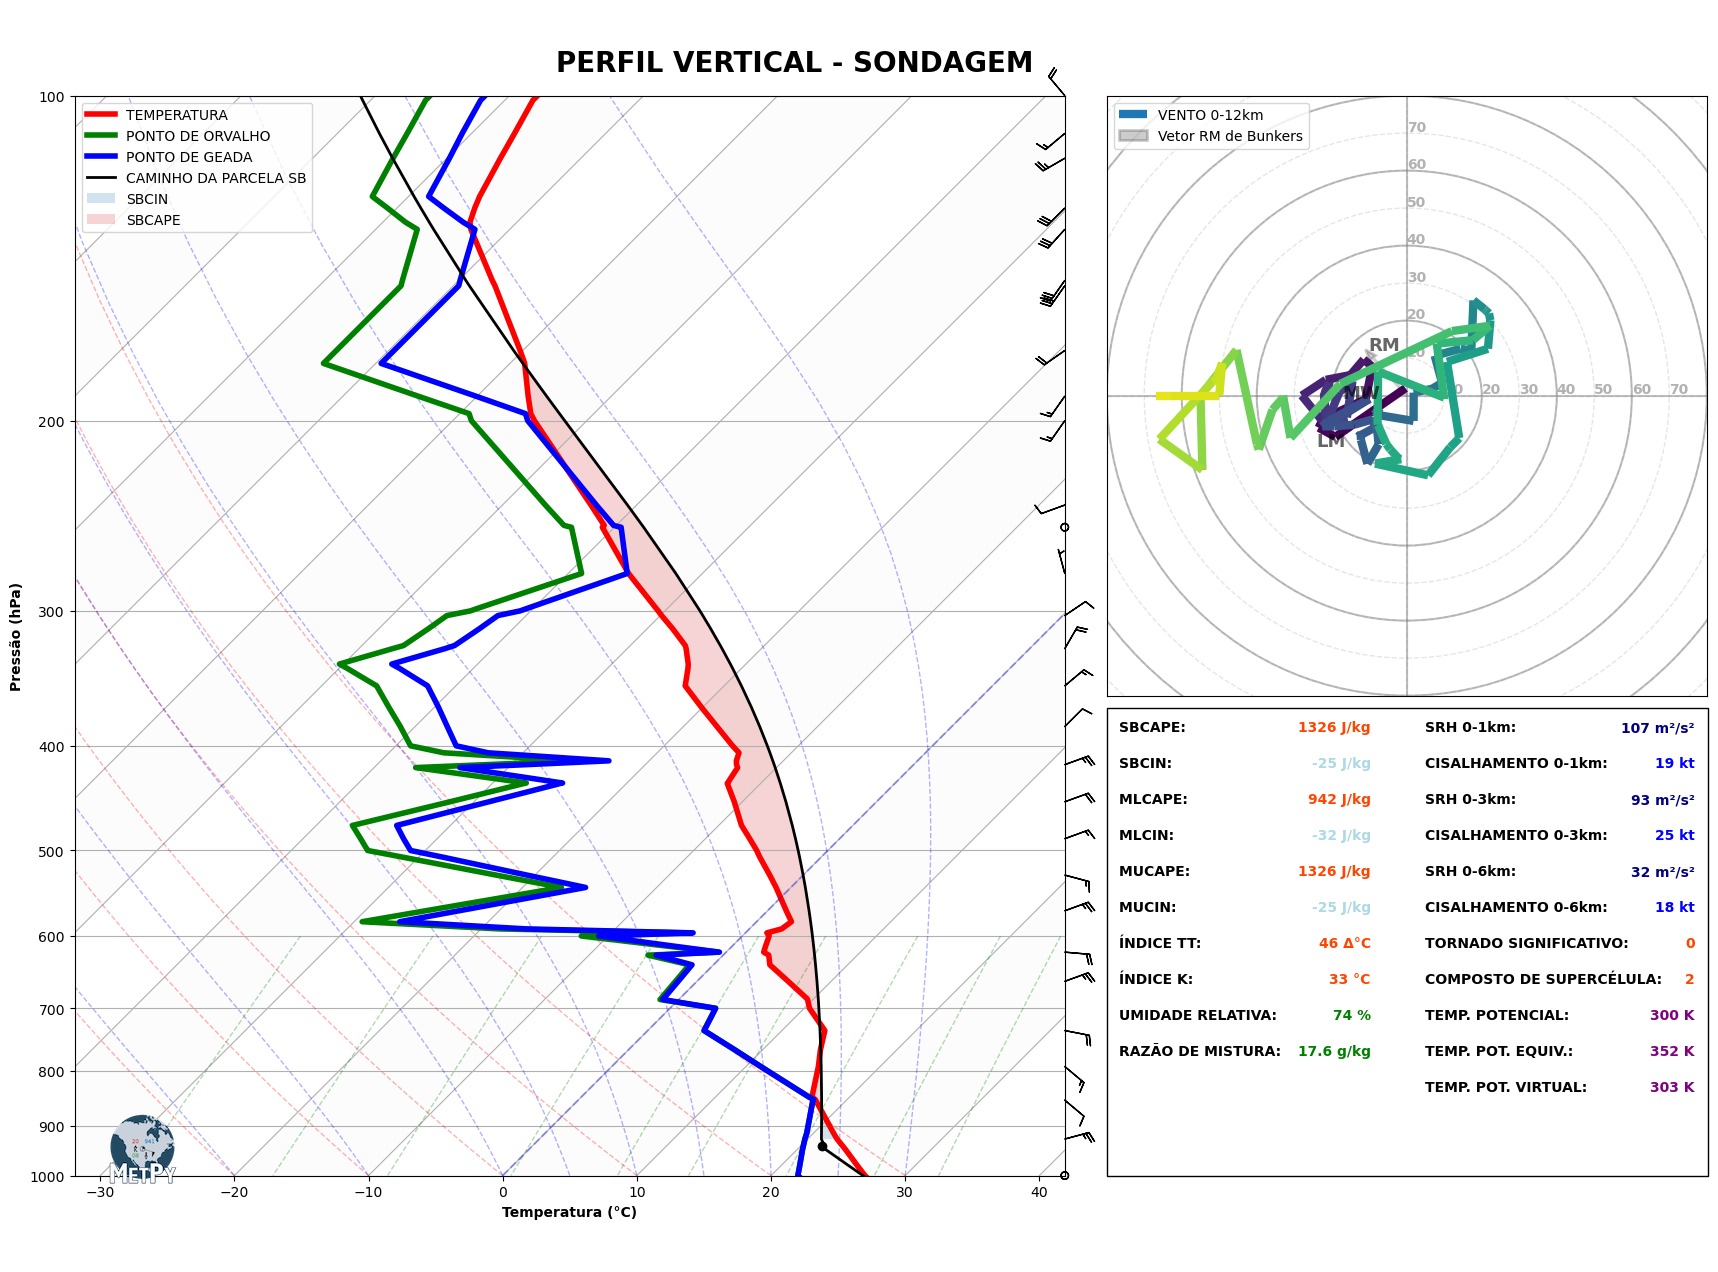

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

# Lendo os dados do arquivo sondagem.csv com todas as colunas desejadas
col_names = [
    'pressure', 'height', 'temperature', 'dewpoint', 'frost_point', 'relativehumidity',
    'relativehumiditywithrespecttoice', 'mixing_ratio', 'direction', 'speed',
    'potentialtemperature', 'equivalentpotentialtemperature', 'virtualpotentialtemperature'
]
usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
df = pd.read_csv('sondagem.csv', skiprows=1, usecols=usecols, names=col_names)

# Removendo linhas com valores NaN para temperatura, ponto de orvalho e ventos
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all').reset_index(drop=True)

# Extraindo variáveis e atribuindo unidades
p = df['pressure'].values * units.hPa
z = df['height'].values * units.m
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
Tf = df['frost_point'].values * units.degC
rh = df['relativehumidity'].values * units.percent
rhi = df['relativehumiditywithrespecttoice'].values * units.percent
mixr = df['mixing_ratio'].values * units('g/kg')
theta = df['potentialtemperature'].values * units.kelvin
theta_e = df['equivalentpotentialtemperature'].values * units.kelvin
theta_v = df['virtualpotentialtemperature'].values * units.kelvin
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Criando a figura com proporções adequadas
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.55, 0.90))  # Aumentei a largura do Skew-T
add_metpy_logo(fig, 105, 85, size='small')

# Ajustando limites de dados e aparência
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperatura (°C)', weight='bold')
skew.ax.set_ylabel('Pressão (hPa)', weight='bold')
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Adicionando padrão de isotermas sombreadas
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# Plotando temperatura, ponto de orvalho, ponto de geada e barbelas de vento
skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
skew.plot(p, Td, 'g', lw=4, label='PONTO DE ORVALHO')
skew.plot(p, Tf, 'b', lw=4, label='PONTO DE GEADA')
interval = np.logspace(2, 3, 30) * units.hPa  # Reduzi o número de barbelas
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx], length=6)  # Ajustei o comprimento das barbelas

# Adicionando linhas especiais e ajustando aparência
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculando e plotando LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculando e plotando perfil da parcela
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='CAMINHO DA PARCELA SB')

# Sombreando áreas de CAPE e CIN
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='SBCIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='SBCAPE')

# Criando o hodógrafo
hodo_ax = plt.axes((0.54, 0.45, 0.5, 0.5))  # Movi o hodógrafo para a direita e reduzi o tamanho
h = Hodograph(hodo_ax, component_range=80.)
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
h.plot_colormapped(u, v, c=z, linewidth=6, label='VENTO 0-12km')

# Calculando movimento de tempestade de Bunkers
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black', alpha=0.2, label='Vetor RM de Bunkers', length_includes_head=True, head_width=2)

# Adicionando retângulo para parâmetros (movi para a direita)
fig.patches.extend([plt.Rectangle((0.6235, 0.05), 0.3339, 0.39, edgecolor='black', facecolor='white', linewidth=1, alpha=1, transform=fig.transFigure, figure=fig)])

# Calculando parâmetros meteorológicos
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km, storm_u=u_storm, storm_v=v_storm)
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height, total_helicity3, bshear3).to_base_units()
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# Plotando parâmetros termodinâmicos
plt.figtext(0.63, 0.42, 'SBCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.42, f'{sbcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.39, 'SBCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.39, f'{sbcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.36, 'MLCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.36, f'{mlcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.33, 'MLCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.33, f'{mlcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.30, 'MUCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.30, f'{mucape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.27, 'MUCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.27, f'{mucin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.24, 'ÍNDICE TT: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.24, f'{total_totals:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.21, 'ÍNDICE K: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.21, f'{kindex:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.18, 'UMIDADE RELATIVA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.18, f'{rh[0]:.0f~P}', weight='bold', fontsize=10, color='green', ha='right')
plt.figtext(0.63, 0.15, 'RAZÃO DE MISTURA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.15, f'{mixr[0]:.1f~P}', weight='bold', fontsize=10, color='green', ha='right')

# Plotando parâmetros cinemáticos
plt.figtext(0.80, 0.42, 'SRH 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.42, f'{total_helicity1:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.39, 'CISALHAMENTO 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.39, f'{bshear1:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.36, 'SRH 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.36, f'{total_helicity3:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.33, 'CISALHAMENTO 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.33, f'{bshear3:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.30, 'SRH 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.30, f'{total_helicity6:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.27, 'CISALHAMENTO 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.27, f'{bshear6:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.24, 'TORNADO SIGNIFICATIVO: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.24, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.21, 'COMPOSTO DE SUPERCÉLULA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.21, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.18, 'TEMP. POTENCIAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.18, f'{theta[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.80, 0.15, 'TEMP. POT. EQUIV.: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.15, f'{theta_e[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.80, 0.12, 'TEMP. POT. VIRTUAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.12, f'{theta_v[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')

# Adicionando legendas
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# Adicionando título
plt.figtext(0.45, 0.97, 'PERFIL VERTICAL - SONDAGEM', weight='bold', fontsize=20, ha='center')

# Exibindo o gráfico
plt.show()

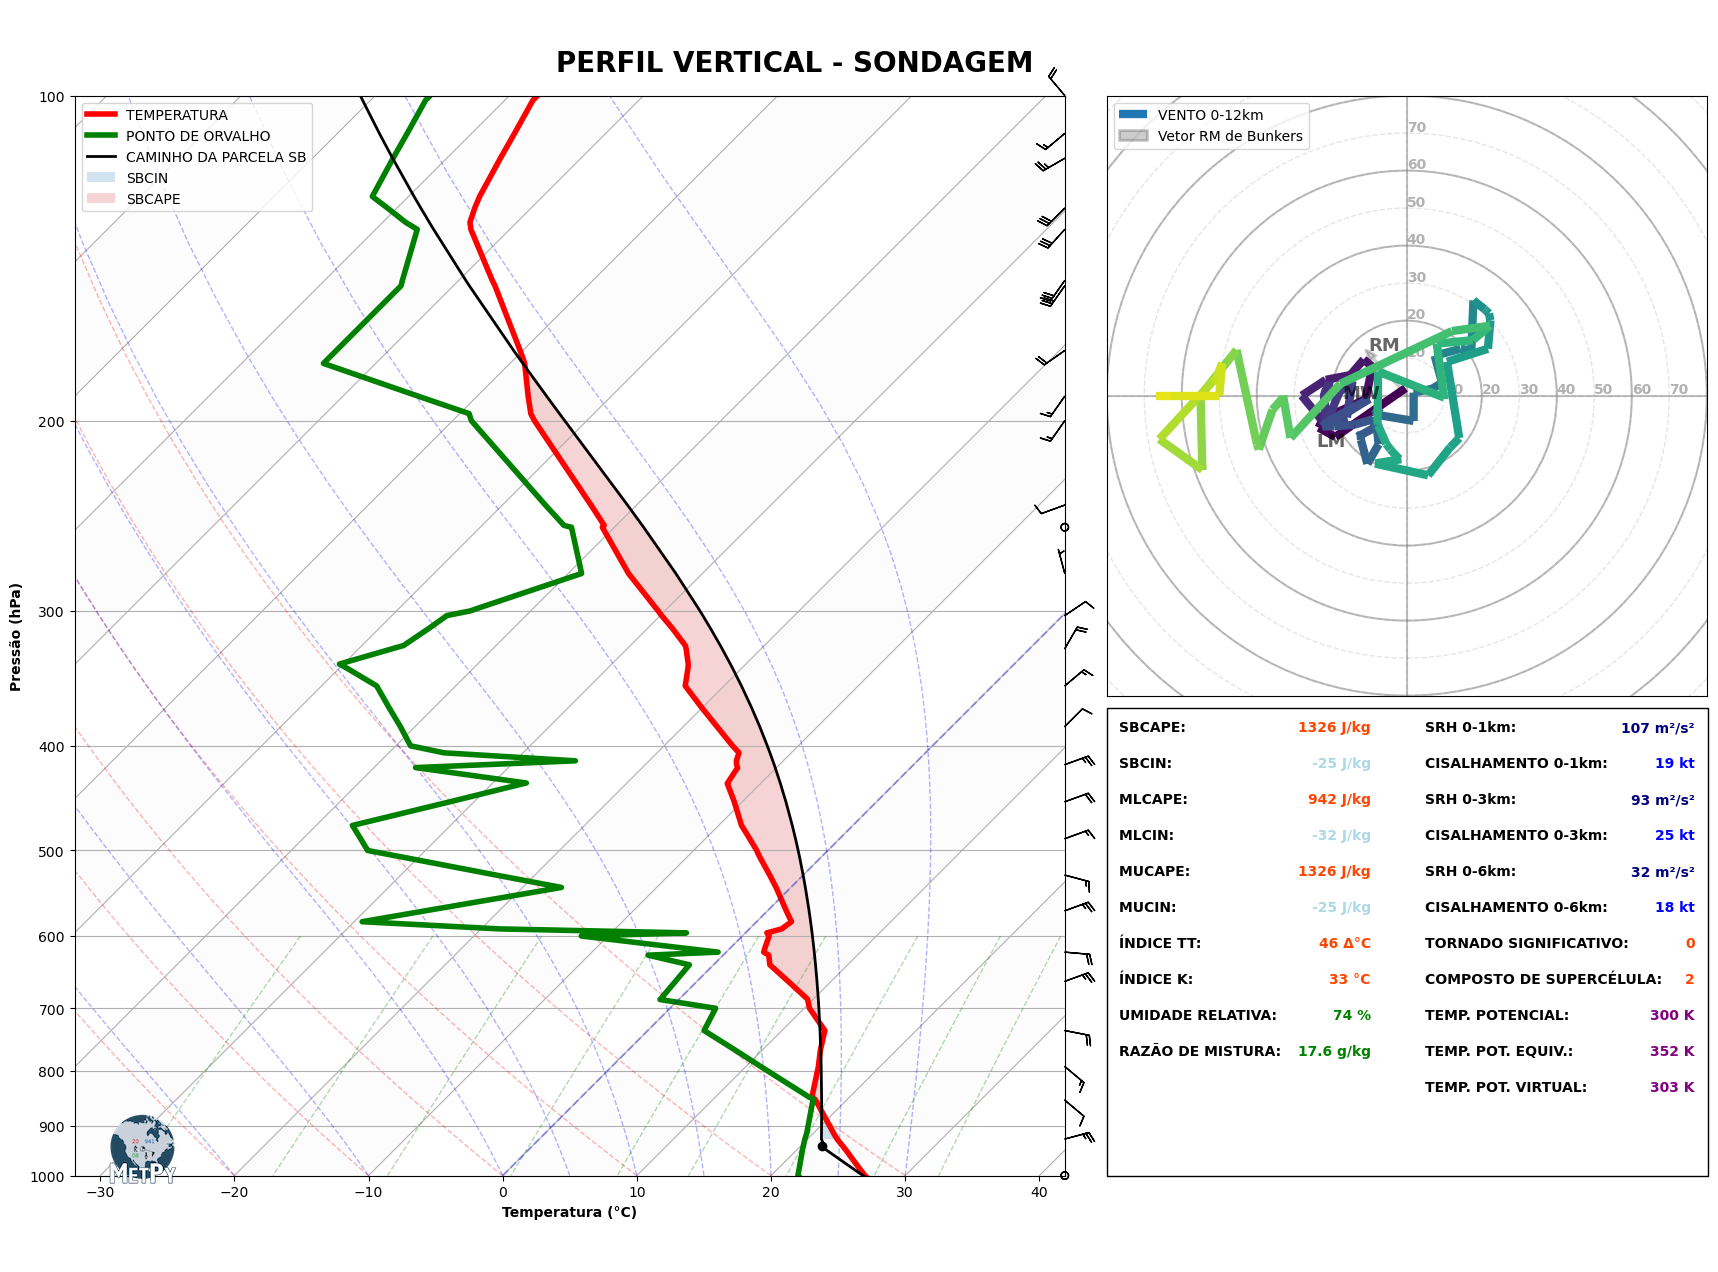

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

# Lendo os dados do arquivo sondagem.csv com todas as colunas desejadas
col_names = [
    'pressure', 'height', 'temperature', 'dewpoint', 'frost_point', 'relativehumidity',
    'relativehumiditywithrespecttoice', 'mixing_ratio', 'direction', 'speed',
    'potentialtemperature', 'equivalentpotentialtemperature', 'virtualpotentialtemperature'
]
usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
df = pd.read_csv('sondagem.csv', skiprows=1, usecols=usecols, names=col_names)

# Removendo linhas com valores NaN para temperatura, ponto de orvalho e ventos
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all').reset_index(drop=True)

# Extraindo variáveis e atribuindo unidades
p = df['pressure'].values * units.hPa
z = df['height'].values * units.m
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
rh = df['relativehumidity'].values * units.percent
rhi = df['relativehumiditywithrespecttoice'].values * units.percent
mixr = df['mixing_ratio'].values * units('g/kg')
theta = df['potentialtemperature'].values * units.kelvin
theta_e = df['equivalentpotentialtemperature'].values * units.kelvin
theta_v = df['virtualpotentialtemperature'].values * units.kelvin
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Criando a figura com proporções adequadas
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.55, 0.90))
add_metpy_logo(fig, 105, 85, size='small')

# Ajustando limites de dados e aparência
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperatura (°C)', weight='bold')
skew.ax.set_ylabel('Pressão (hPa)', weight='bold')
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Adicionando padrão de isotermas sombreadas
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# Plotando temperatura, ponto de orvalho e barbelas de vento
skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
skew.plot(p, Td, 'g', lw=4, label='PONTO DE ORVALHO')
interval = np.logspace(2, 3, 30) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx], length=6)

# Adicionando linhas especiais e ajustando aparência
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculando e plotando LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculando e plotando perfil da parcela
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='CAMINHO DA PARCELA SB')

# Sombreando áreas de CAPE e CIN
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='SBCIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='SBCAPE')

# Criando o hodógrafo
hodo_ax = plt.axes((0.54, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
h.plot_colormapped(u, v, c=z, linewidth=6, label='VENTO 0-12km')

# Calculando movimento de tempestade de Bunkers
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black', alpha=0.2, label='Vetor RM de Bunkers', length_includes_head=True, head_width=2)

# Adicionando retângulo para parâmetros
fig.patches.extend([plt.Rectangle((0.6235, 0.05), 0.3339, 0.39, edgecolor='black', facecolor='white', linewidth=1, alpha=1, transform=fig.transFigure, figure=fig)])

# Calculando parâmetros meteorológicos
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km, storm_u=u_storm, storm_v=v_storm)
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height, total_helicity3, bshear3).to_base_units()
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# Plotando parâmetros termodinâmicos
plt.figtext(0.63, 0.42, 'SBCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.42, f'{sbcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.39, 'SBCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.39, f'{sbcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.36, 'MLCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.36, f'{mlcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.33, 'MLCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.33, f'{mlcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.30, 'MUCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.30, f'{mucape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.27, 'MUCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.27, f'{mucin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.24, 'ÍNDICE TT: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.24, f'{total_totals:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.21, 'ÍNDICE K: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.21, f'{kindex:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.18, 'UMIDADE RELATIVA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.18, f'{rh[0]:.0f~P}', weight='bold', fontsize=10, color='green', ha='right')
plt.figtext(0.63, 0.15, 'RAZÃO DE MISTURA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.15, f'{mixr[0]:.1f~P}', weight='bold', fontsize=10, color='green', ha='right')

# Plotando parâmetros cinemáticos
plt.figtext(0.80, 0.42, 'SRH 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.42, f'{total_helicity1:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.39, 'CISALHAMENTO 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.39, f'{bshear1:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.36, 'SRH 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.36, f'{total_helicity3:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.33, 'CISALHAMENTO 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.33, f'{bshear3:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.30, 'SRH 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.30, f'{total_helicity6:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.27, 'CISALHAMENTO 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.27, f'{bshear6:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.24, 'TORNADO SIGNIFICATIVO: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.24, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.21, 'COMPOSTO DE SUPERCÉLULA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.21, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.18, 'TEMP. POTENCIAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.18, f'{theta[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.80, 0.15, 'TEMP. POT. EQUIV.: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.15, f'{theta_e[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.80, 0.12, 'TEMP. POT. VIRTUAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.12, f'{theta_v[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')

# Adicionando legendas
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# Adicionando título
plt.figtext(0.45, 0.97, 'PERFIL VERTICAL - SONDAGEM', weight='bold', fontsize=20, ha='center')

# Exibindo o gráfico
plt.show()

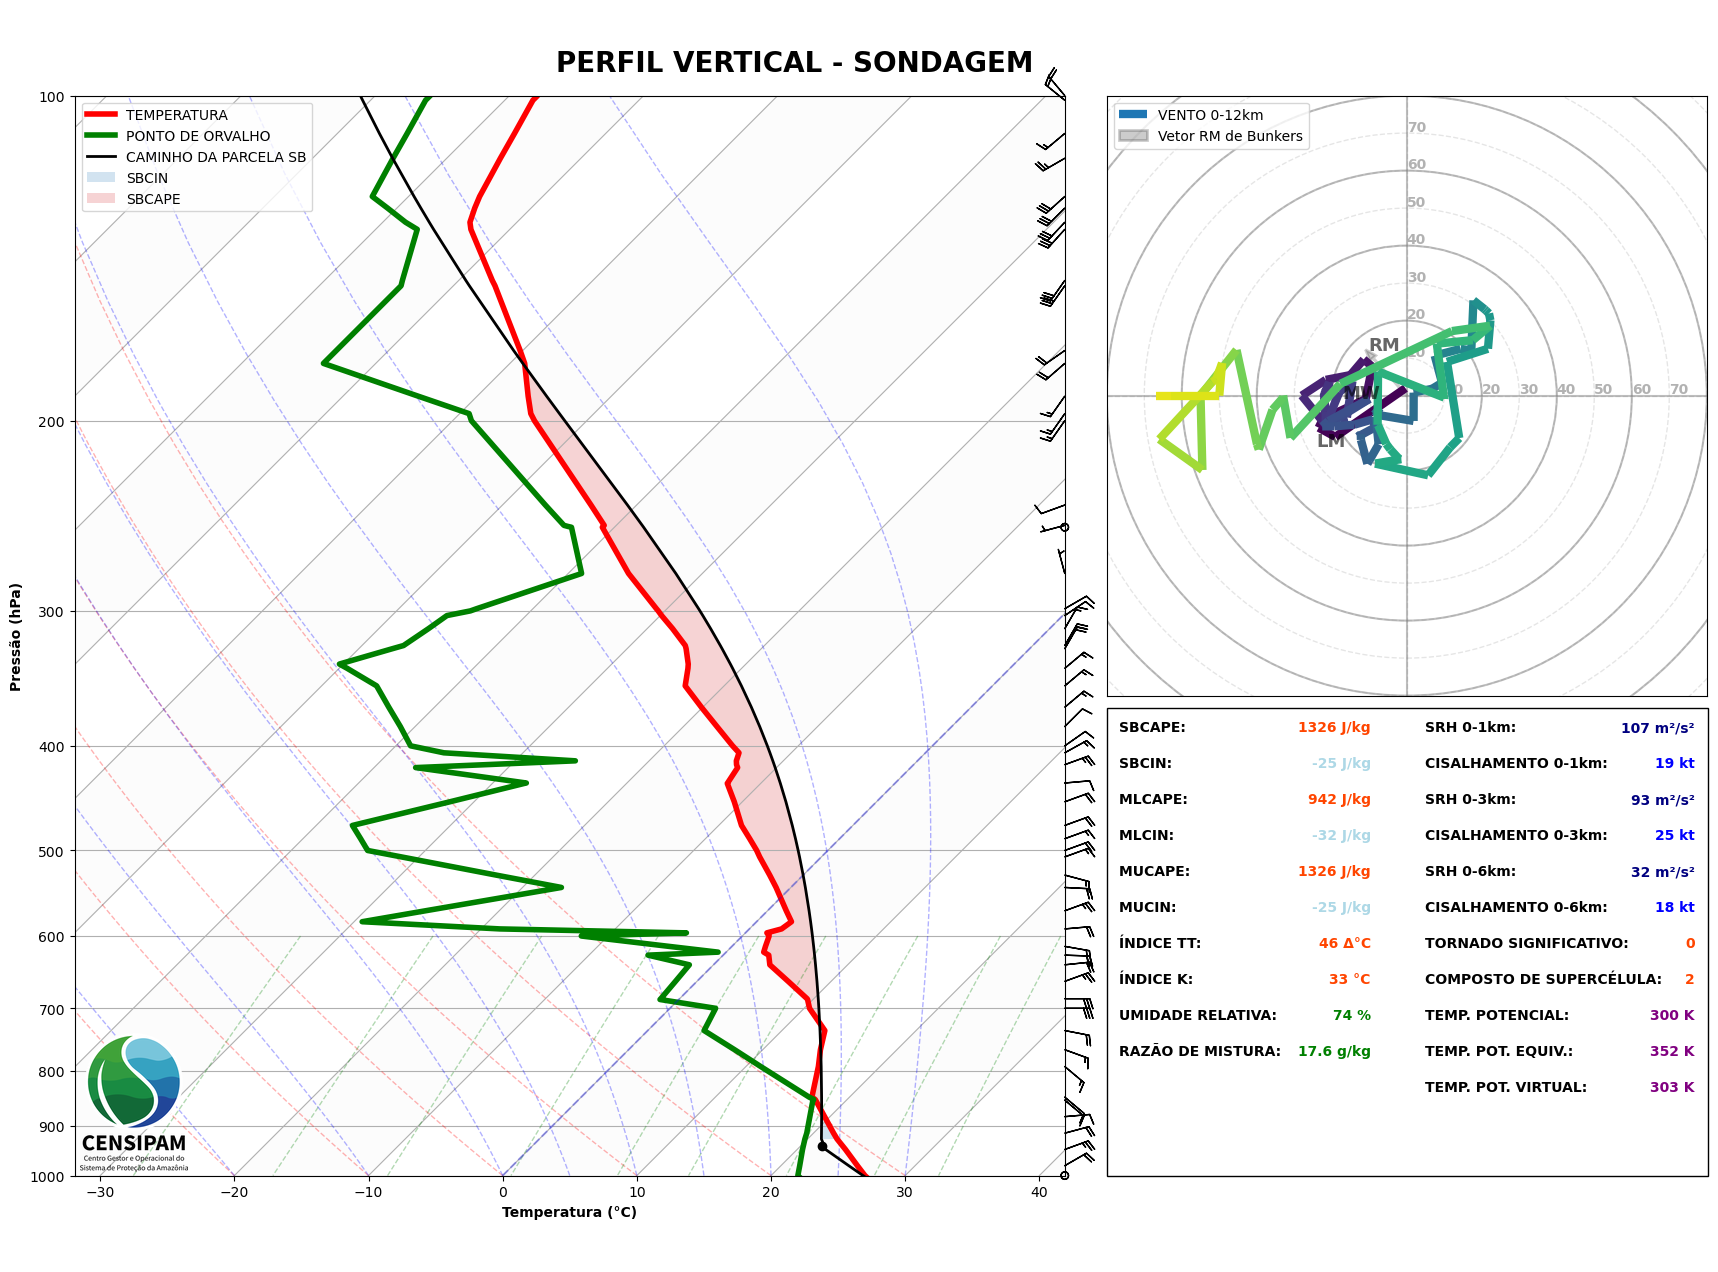

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from PIL import Image

# Lendo os dados do arquivo sondagem.csv com todas as colunas desejadas
col_names = [
    'pressure', 'height', 'temperature', 'dewpoint', 'frost_point', 'relativehumidity',
    'relativehumiditywithrespecttoice', 'mixing_ratio', 'direction', 'speed',
    'potentialtemperature', 'equivalentpotentialtemperature', 'virtualpotentialtemperature'
]
usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
df = pd.read_csv('sondagem.csv', skiprows=1, usecols=usecols, names=col_names)

# Removendo linhas com valores NaN para temperatura, ponto de orvalho e ventos
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all').reset_index(drop=True)

# Extraindo variáveis e atribuindo unidades
p = df['pressure'].values * units.hPa
z = df['height'].values * units.m
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
rh = df['relativehumidity'].values * units.percent
rhi = df['relativehumiditywithrespecttoice'].values * units.percent
mixr = df['mixing_ratio'].values * units('g/kg')
theta = df['potentialtemperature'].values * units.kelvin
theta_e = df['equivalentpotentialtemperature'].values * units.kelvin
theta_v = df['virtualpotentialtemperature'].values * units.kelvin
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Criando a figura com proporções adequadas
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.55, 0.90))

# Adicionando a imagem personalizada (LogoCensipam.png) com tamanho ajustado
logo = Image.open('LogoCensipam.png')  # Carrega a imagem PNG
# Redimensionar a imagem para 50% do tamanho original (ajuste o fator conforme necessário)
new_size = (int(logo.width * 0.1), int(logo.height * 0.1))
logo_resized = logo.resize(new_size, Image.Resampling.LANCZOS)  # Usa LANCZOS para melhor qualidade
logo_array = np.array(logo_resized)  # Converte para array NumPy para uso no Matplotlib
fig.figimage(logo_array, xo=80, yo=100, zorder=10, alpha=1.0)  # Posiciona a imagem

# Ajustando limites de dados e aparência
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperatura (°C)', weight='bold')
skew.ax.set_ylabel('Pressão (hPa)', weight='bold')
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Adicionando padrão de isotermas sombreadas
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# Plotando temperatura, ponto de orvalho e barbelas de vento
skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
skew.plot(p, Td, 'g', lw=4, label='PONTO DE ORVALHO')
interval = np.logspace(2, 3, 80) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx], length=6)

# Adicionando linhas especiais e ajustando aparência
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculando e plotando LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculando e plotando perfil da parcela
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='CAMINHO DA PARCELA SB')

# Sombreando áreas de CAPE e CIN
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='SBCIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='SBCAPE')

# Criando o hodógrafo
hodo_ax = plt.axes((0.54, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
h.plot_colormapped(u, v, c=z, linewidth=6, label='VENTO 0-12km')

# Calculando movimento de tempestade de Bunkers
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black', alpha=0.2, label='Vetor RM de Bunkers', length_includes_head=True, head_width=2)

# Adicionando retângulo para parâmetros
fig.patches.extend([plt.Rectangle((0.6235, 0.05), 0.3339, 0.39, edgecolor='black', facecolor='white', linewidth=1, alpha=1, transform=fig.transFigure, figure=fig)])

# Calculando parâmetros meteorológicos
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km, storm_u=u_storm, storm_v=v_storm)
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height, total_helicity3, bshear3).to_base_units()
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# Plotando parâmetros termodinâmicos
plt.figtext(0.63, 0.42, 'SBCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.42, f'{sbcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.39, 'SBCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.39, f'{sbcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.36, 'MLCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.36, f'{mlcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.33, 'MLCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.33, f'{mlcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.30, 'MUCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.30, f'{mucape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.27, 'MUCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.27, f'{mucin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.24, 'ÍNDICE TT: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.24, f'{total_totals:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.21, 'ÍNDICE K: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.21, f'{kindex:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.18, 'UMIDADE RELATIVA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.18, f'{rh[0]:.0f~P}', weight='bold', fontsize=10, color='green', ha='right')
plt.figtext(0.63, 0.15, 'RAZÃO DE MISTURA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.15, f'{mixr[0]:.1f~P}', weight='bold', fontsize=10, color='green', ha='right')

# Plotando parâmetros cinemáticos
plt.figtext(0.80, 0.42, 'SRH 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.42, f'{total_helicity1:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.39, 'CISALHAMENTO 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.39, f'{bshear1:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.36, 'SRH 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.36, f'{total_helicity3:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.33, 'CISALHAMENTO 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.33, f'{bshear3:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.30, 'SRH 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.30, f'{total_helicity6:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.27, 'CISALHAMENTO 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.27, f'{bshear6:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.24, 'TORNADO SIGNIFICATIVO: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.24, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.21, 'COMPOSTO DE SUPERCÉLULA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.21, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.18, 'TEMP. POTENCIAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.18, f'{theta[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.80, 0.15, 'TEMP. POT. EQUIV.: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.15, f'{theta_e[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.80, 0.12, 'TEMP. POT. VIRTUAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.12, f'{theta_v[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')

# Adicionando legendas
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# Adicionando título
plt.figtext(0.45, 0.97, 'PERFIL VERTICAL - SONDAGEM', weight='bold', fontsize=20, ha='center')

# Exibindo o gráfico
plt.show()

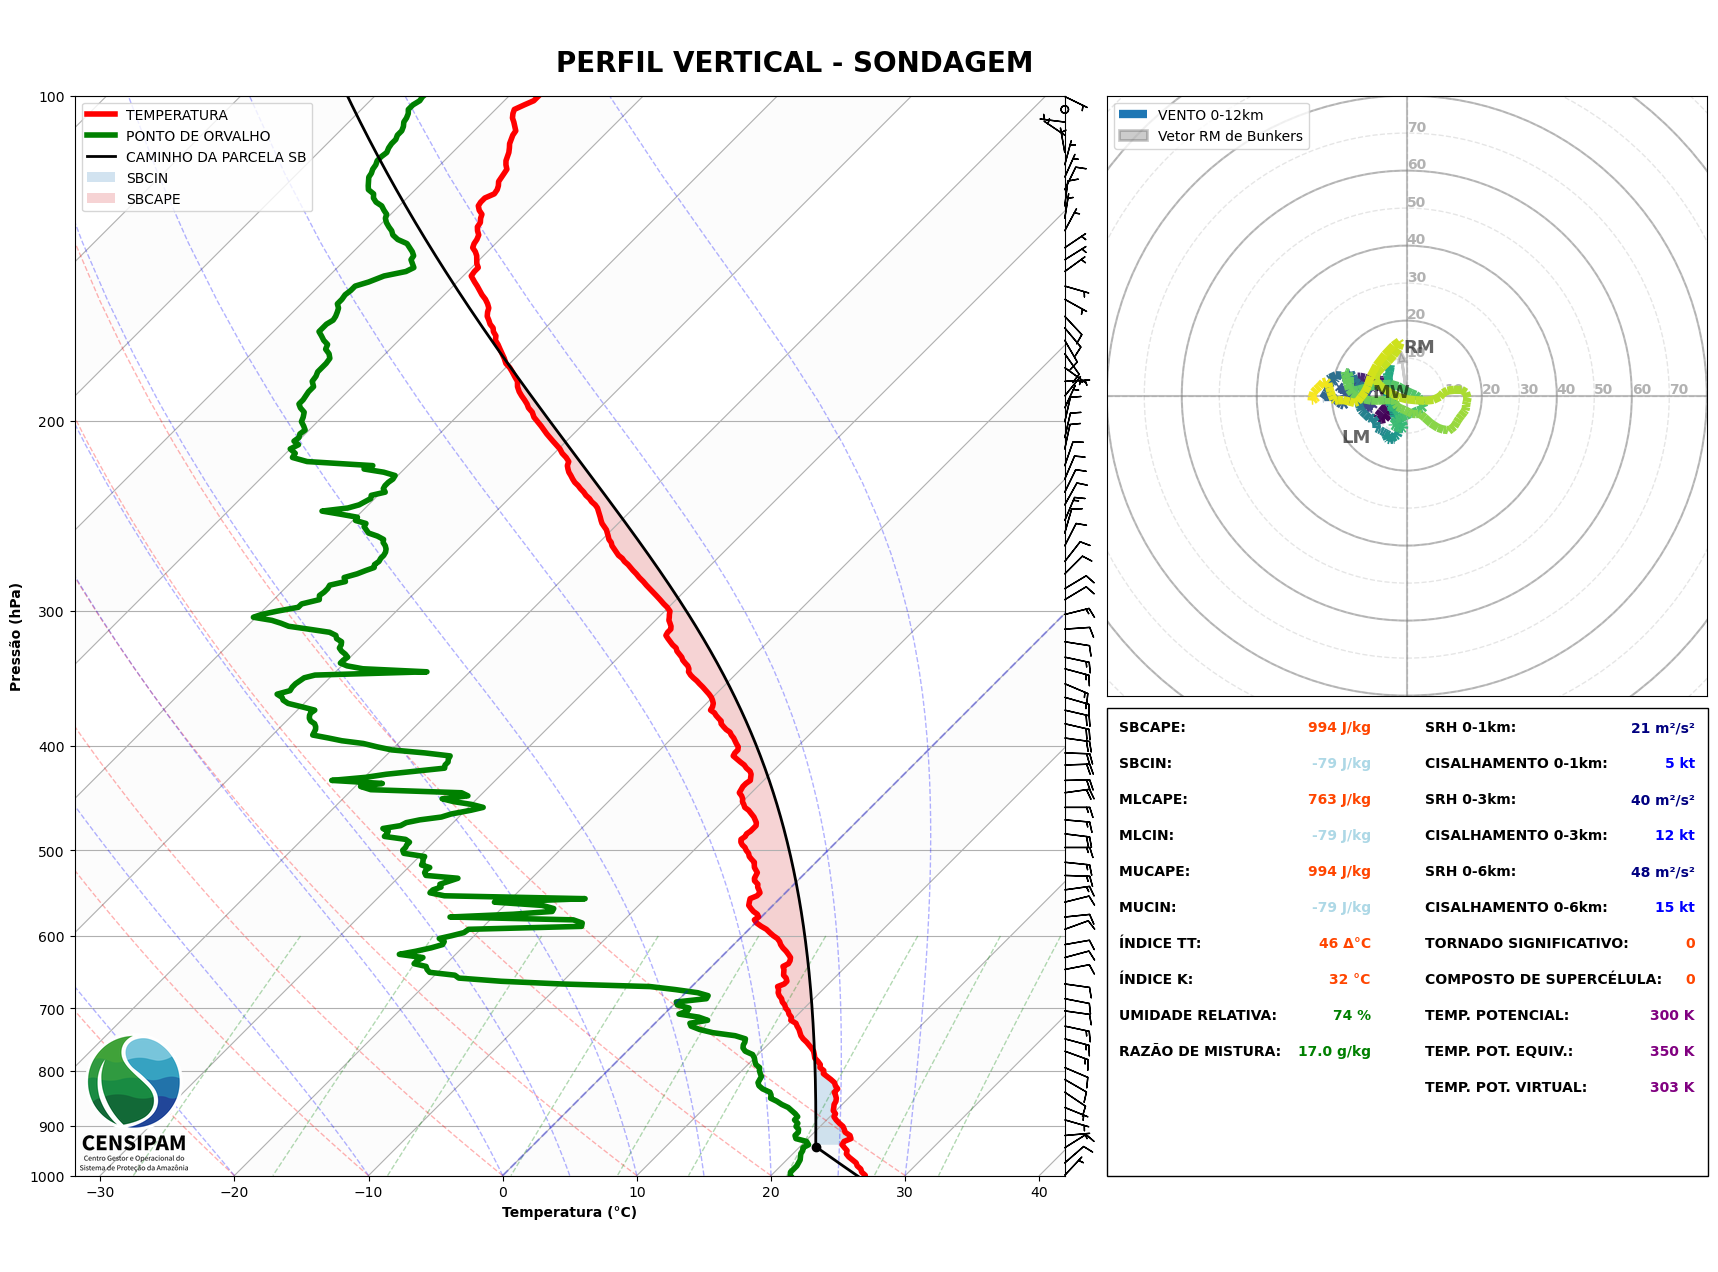

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from PIL import Image

# Lendo os dados do arquivo sondagem.csv com o novo cabeçalho
col_names = ['pressure', 'height', 'temperature', 'rh', 'dewpoint', 'speed', 'direction']
df = pd.read_csv('sondagem.csv', skiprows=1, names=col_names)

# Removendo linhas com valores NaN para temperatura, ponto de orvalho e ventos
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all').reset_index(drop=True)

# Extraindo variáveis e atribuindo unidades
p = df['pressure'].values * units.hPa
z = df['height'].values * units.m
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
rh = df['rh'].values * units.percent
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees

# Calculando variáveis adicionais necessárias
mixr = mpcalc.mixing_ratio_from_relative_humidity(p, T, rh).to('g/kg')
theta = mpcalc.potential_temperature(p, T).to('kelvin')
theta_e = mpcalc.equivalent_potential_temperature(p, T, Td).to('kelvin')
theta_v = mpcalc.virtual_potential_temperature(p, T, mixr).to('kelvin')
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Criando a figura com proporções adequadas
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.55, 0.90))

# Adicionando a imagem personalizada (LogoCensipam.png) com tamanho ajustado
logo = Image.open('LogoCensipam.png')  # Carrega a imagem PNG
new_size = (int(logo.width * 0.1), int(logo.height * 0.1))
logo_resized = logo.resize(new_size, Image.Resampling.LANCZOS)
logo_array = np.array(logo_resized)
fig.figimage(logo_array, xo=80, yo=100, zorder=10, alpha=1.0)

# Ajustando limites de dados e aparência
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperatura (°C)', weight='bold')
skew.ax.set_ylabel('Pressão (hPa)', weight='bold')
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Adicionando padrão de isotermas sombreadas
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# Plotando temperatura, ponto de orvalho e barbelas de vento
skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
skew.plot(p, Td, 'g', lw=4, label='PONTO DE ORVALHO')
interval = np.logspace(2, 3, 80) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx], length=6)

# Adicionando linhas especiais e ajustando aparência
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculando e plotando LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculando e plotando perfil da parcela
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='CAMINHO DA PARCELA SB')

# Sombreando áreas de CAPE e CIN
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='SBCIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='SBCAPE')

# Criando o hodógrafo
hodo_ax = plt.axes((0.54, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
h.plot_colormapped(u, v, c=z, linewidth=6, label='VENTO 0-12km')

# Calculando movimento de tempestade de Bunkers
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black', alpha=0.2, label='Vetor RM de Bunkers', length_includes_head=True, head_width=2)

# Adicionando retângulo para parâmetros
fig.patches.extend([plt.Rectangle((0.6235, 0.05), 0.3339, 0.39, edgecolor='black', facecolor='white', linewidth=1, alpha=1, transform=fig.transFigure, figure=fig)])

# Calculando parâmetros meteorológicos
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km, storm_u=u_storm, storm_v=v_storm)
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height, total_helicity3, bshear3).to_base_units()
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# Plotando parâmetros termodinâmicos
plt.figtext(0.63, 0.42, 'SBCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.42, f'{sbcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.39, 'SBCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.39, f'{sbcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.36, 'MLCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.36, f'{mlcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.33, 'MLCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.33, f'{mlcin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.30, 'MUCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.30, f'{mucape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.27, 'MUCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.27, f'{mucin:.0f~P}', weight='bold', fontsize=10, color='lightblue', ha='right')
plt.figtext(0.63, 0.24, 'ÍNDICE TT: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.24, f'{total_totals:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.21, 'ÍNDICE K: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.21, f'{kindex:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.18, 'UMIDADE RELATIVA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.18, f'{rh[0]:.0f~P}', weight='bold', fontsize=10, color='green', ha='right')
plt.figtext(0.63, 0.15, 'RAZÃO DE MISTURA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.15, f'{mixr[0]:.1f~P}', weight='bold', fontsize=10, color='green', ha='right')

# Plotando parâmetros cinemáticos
plt.figtext(0.80, 0.42, 'SRH 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.42, f'{total_helicity1:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.39, 'CISALHAMENTO 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.39, f'{bshear1:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.36, 'SRH 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.36, f'{total_helicity3:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.33, 'CISALHAMENTO 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.33, f'{bshear3:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.30, 'SRH 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.30, f'{total_helicity6:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.27, 'CISALHAMENTO 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.27, f'{bshear6:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.24, 'TORNADO SIGNIFICATIVO: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.24, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.21, 'COMPOSTO DE SUPERCÉLULA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.21, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.18, 'TEMP. POTENCIAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.18, f'{theta[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.80, 0.15, 'TEMP. POT. EQUIV.: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.15, f'{theta_e[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')
plt.figtext(0.80, 0.12, 'TEMP. POT. VIRTUAL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.12, f'{theta_v[0]:.0f~P}', weight='bold', fontsize=10, color='purple', ha='right')

# Adicionando legendas
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# Adicionando título
plt.figtext(0.45, 0.97, 'PERFIL VERTICAL - SONDAGEM', weight='bold', fontsize=20, ha='center')

# Exibindo o gráfico
plt.show()